# Reinforcement Learning

This tutorial will walk through some initial concepts and algorithms for reinforcement learning (RL). I'll assume you've already done the general introduction on supervised learning with Tensorflow. We'll start with basic Q-learning to introduce the concept of RL, but you will need to be familiar with Tensorflow models for some of the later algorithms.

Additionally, the focus of this tutorial will be on RL in control applications. We'll start by introducing some basic concepts followed by an example with the pendulum problem.

## Markov Decision Process (MDP)

Reinfocement learning problems seek to find a solution to an MDP which maximizes a reward. An MDP is represented by a set of states $S$, a set of actions $A$, a reward function $R(s_t,a_t,s_{t+1}) : S \times A \times S \rightarrow \mathbb{R}$, and a transition function $P(s_t,a_t,s_{t+1}) : S \times A \times S \rightarrow [0,1]$. The reward function maps a transition $(s_t,a_t,s_{t+1})$ to a scalar reward. In many cases this may be simplified to a function of state-action pairs $(s_t,a_t)$ or just state. The transition function returns the probability that a state-action pair $(s_t,a_t)$ will result in a given state $s_{t+1}$. A solution to an MDP is a policy $\pi(a_t|s_t) : A \times S \rightarrow \mathbb{R}$ which gives the probability of an action $a_t$ given the current state $s_t$. For deterministic policies this may also be written as $\mu(s_t) : S \rightarrow A$ which returns an action given the current state.

MDPs often have a discount factor $0 \leq \gamma < 1$ to weight immediate rewards more favorably than future rewards. In this case the objective of the policy is to maximize the return of a trajectory $\tau = \{ (s_0, a_0), (s_1, a_1), ..., (s_T, a_T)\}$. The return is defined as $G = \sum_{t=0}^{T-1} \gamma^t R(s_t, a_t, s_{t+1})$.

## Control Theory

Control problems can be modeled as an MDP with some minor tweaks and typically different notation. For notation, the state space is often denoted as $X$ and the action space is called the control space denoted as $U$. The reward function is also typically replaced with a cost function $J(x,u)$ which we wish to minimize. The transition function is analogous to the system dynamics $\dot{x} = f(x,u,w,t)$. We'll mostly be working with deterministic, time-invariant systems represented by the simplified expression $\dot{x} = f(x,u)$. The following notebook will be dealing with simulations and numerical algorithms, so it's also convenient to work with a discrete-time representation $x_{t+1} = f(x_t, u_t)$. In this representation the parallels to MDPs should be fairly obvious. 

## Value Iteration

Value iteration is one algorithm for solving MDPs if the transition and reward functions are known. Understanding how it works will provide some insight into the RL algorithms we discuss later, which have no direct access to the transition or reward function. Value iteration is based on the principal of optimality. In simple terms, this states that the tail end of any optimal trajectory is also optimal. In more mathematical terms, if you have an optimal trajectory from $x_0$ to $x_T$ which passes through $x_t$ then the portion of that trajectory from $x_t$ to $x_T$ is the optimal solution from $x_t$. This is the basic for dynamic programming methods, which typically find optimal solutions by working backwards from the goal finding optimal solutions to subproblems. Value iteration does this by iteratively solving the following equation:

$V_{i+1}(s_t) = \max_{a_t} \sum_{s_{t+1}}P(s_t, a_t, s_{t+1})\left[R(s_t, a_t, s_{t+1}) + \gamma V_i(s_{t+1})\right]$

In the discrete case, this is guaranteed to converge to an optimal solution $V^*$ which has the following property:

$V^*(s_t) = \max_{a_t} \sum_{s_{t+1}}P(s_t, a_t, s_{t+1})\left[R(s_t, a_t, s_{t+1}) + \gamma V^*(s_{t+1})\right]$

The optimal policy for the MDP is given by:

$\pi^*(s_t) = \arg\max_{a_t} \sum_{s_{t+1}}P(s_t, a_t, s_{t+1})\left[R(s_t, a_t, s_{t+1}) + \gamma V^*(s_{t+1})\right]$

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

from IPython import display

%matplotlib inline

## Loading Gym Environments

OpenAI's Gym has a range of environments designed for RL experiments load in and use out-of-the-box. These environments include a simple cartpole problem. This environment gives the position and velocity of the cart and the angle and angular rate of the pendulum as the observation. There are two possible actions for the agent: push left or push right. The agent receives a reward of +1 every time step until the cart position or pendulum angle pass a given threshold. 

In [3]:
env = gym.make("Pendulum-v1")

print("Observation:", env.observation_space)
print("Action:", env.action_space)

Observation: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action: Box([-2.], [2.], (1,), float32)


We can quickly visualize this environment to see how an agent is performing. Since we don't yet have an agent, we'll just sample actions randomly. Of course, this policy won't last long before failing.

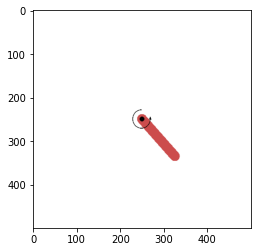

In [3]:
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()

## Q-Learning

We start by solving this environment with the Q-learning algorithm. This isn't a *Deep* RL algorithm, but it provides a more clear example of the principles that later algorithms will be working off of. 

The objective of Q-Learning (and many algorithms we explore later) is to learn a q-function which $Q : S \times A \rightarrow \mathbb{R}$ predicts the value for taking an action at a given state. This is similar to the value function in Value Iteration, but determines the value for state-action pairs instead of state alone. Similarly to value iteration, the optimal q-function should satisfy the following condition:

$Q^*(s_t, a_t) = \sum_{s_{t+1}} P(s_t, a_t, s_{t+t}) \left[R(s_t, a_t, s_{t+1}) + \gamma \max_{a_{t+1}} Q^*(s_{t+1}, a_{t+1})\right]$

Regular Q-Learning represents this function as a look-up table and learns each value through dynamic programming. Since we don't have access to the transition function or reward function, we have to learn this function by sampling experience. Experience is sampled from the environment as transitions in the form $(s_t, a_t, s_{t+1})$. Each time new experience is sampled, the Q value is updated by the equation:

$Q(s_t, a_t) \leftarrow (1 - \alpha) Q(s_t, a_t) + \alpha \left[R(s_t, a_t, s_{t+1}) + \gamma \max_a Q(s_{t+1}, a)\right]$

The learning rate $\alpha$ is typically a small value which can be adjusted to change how fast the q-function is updated. This soft update allows the q-function to approximate stochastic transitions. The pendulum environment is deterministic, but we need to discretize the state space to create a tabular q-function. The soft update helps since our discretized state space doesn't perfectly represent the actual state.

In [4]:
theta = np.linspace(-np.pi, np.pi, 21)
thetadot = np.arange(-8, 7.6, .5)
thetadot[0] = -np.inf # Setting first entry to neg. infinity for numerical errors

print("Angle Break Points:", theta)
print("Angular Rate Break Points:", thetadot)

N = theta.shape[0]*thetadot.shape[0]

print("Number of States:", N)

Q = np.zeros((N,3))


# Maps the continuous angle and angular rate to a discrete state value
def state_map(obs):
    angle = np.arctan2(obs[1], obs[0])
    i = np.nonzero(theta <= angle)[0][-1]
    j = np.nonzero(thetadot <= obs[2])[0][-1]
    
    return j + i*thetadot.shape[0]

# Maps the action index to a continuous action
def action_map(action):
    if action == 0:
        return np.array([-2])
    elif action == 1:
        return np.array([0])
    else:
        return np.array([2])

Angle Break Points: [-3.14159265 -2.82743339 -2.51327412 -2.19911486 -1.88495559 -1.57079633
 -1.25663706 -0.9424778  -0.62831853 -0.31415927  0.          0.31415927
  0.62831853  0.9424778   1.25663706  1.57079633  1.88495559  2.19911486
  2.51327412  2.82743339  3.14159265]
Angular Rate Break Points: [-inf -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5
 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5
  6.   6.5  7.   7.5]
Number of States: 672


### Training a Q Table

Now we just need to collect some experience and update our Q function until it converges on a successful policy. When you run the following cell it will show you the average return for the last 100 episodes. You can use this to gauge how well the policy is doing. If you run the cell multiple times it will continue training the Q-table from where it left off. You may need to run it a few times before it settles on a final value. The average return should settle around -400 to -500.

In [7]:
lr = 0.1
returns = []
for i in range(1000):
    obs = env.reset()
    total_return = 0
    done = False
    while not done:
        ind = state_map(obs)
        if np.random.rand() > .2:
            action = np.argmax(Q[ind])
        else:
            action = np.random.randint(3)
        obs, reward, done, _ = env.step(action_map(action))
        total_return += reward

        Q[ind, action] = (1 - lr) * Q[ind, action] + lr * (reward + 0.99 * np.max(Q[state_map(obs)]))
    
    returns.append(total_return)
    if len(returns) > 100:
        returns.pop(0)
    print("Episode {}: Running Average = {}".format(i, sum(returns)/len(returns)), flush=True, end='\r')
    
env.close()

### Visualizing the Final Policy

Now that we've trained a Q function we can visualize how well it performs. It should be able to swing the pendulum up and hold it mostly upright. It probably won't be perfect for every initialization. Try going back to the training loop and adjusting the learning rate to get a slightly better performance. You should be able to get it to settle around an average return of -300. 

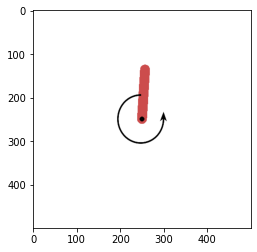

In [9]:
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    ind = state_map(obs)
    action = np.argmax(Q[ind])
    obs, reward, done, _ = env.step(action_map(action))

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()

## Deep Q-Learning

Now we'll move on to the actual *Deep* Learning part. The table does alright for the pendulum, but the number of states you need to store will explode with higher dimensional state spaces and finer resolutions. It would be better if we can store the Q value as a function of the state instead of a look up table. We'll need a function approximator, which could be a few different things such as a linear model or interpolator. The popular choice, and arguably most powerful, is a deep neural network which is also where the following methods get the name *Deep* Reinforcement Learning. You'll want to complete the Introduction notebook before continuing if you haven't already.

The first algorithm we'll look at is the Deep Q Network. This method uses a deep neural network to estimate Q values for a discrete set of actions given any point in a continuous state space. We'll denote the Q function represented by this network as $Q_\theta (s, a)$ where $\theta$ is the set of parameters for the network. We have to update these parameters in a way that moves the Q function towards the target value at the sampled state. 

In [82]:
class QNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__()
        
        # Add some dense layers with ReLU activations
        self.hidden_layer1 = tf.keras.layers.Dense(128, activation='relu')
        self.hidden_layer2 = tf.keras.layers.Dense(64, activation='relu')

        # Add a layer for the output value
        self.value = tf.keras.layers.Dense(num_actions)
    
    @tf.function
    def call(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        return self.value(x)

In [92]:
class QAgent:
    def __init__(self, model):
        self.model = model
        self.gamma = 0.95
        
        # Create an optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    def action(self, state):
        action = np.argmax(self.model(state).numpy())
        return action
    
    def train(self, experience):
        state, action, reward, next_state, done = experience

        # This line lets us record gradients
        with tf.GradientTape() as tape:
            target = reward + self.gamma * tf.stop_gradient(tf.reduce_max(self.model(next_state), 1)) * (1 - done)
            td_error = tf.reduce_sum(self.model(state) * tf.one_hot(action, 3), 1) - target
            loss = tf.reduce_mean(td_error**2, 0)
            
        # Get gradients and apply them to the model's parameters
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

In [93]:
model = QNetwork(3)
agent = QAgent(model)

In [94]:
model(np.expand_dims(env.reset(), 0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.04323262, -0.02003453,  0.2323629 ]], dtype=float32)>

In [95]:
agent.action(np.expand_dims(env.reset(), 0))

2

In [96]:
returns = []
for i in range(1000):
    obs = env.reset()
    obs = np.expand_dims(obs, 0)
    total_return = 0
    done = False
    while not done:
        
        if np.random.rand() > .2:
            action = agent.action(obs)
        else:
            action = np.random.randint(3)
        next_obs, reward, done, _ = env.step(action_map(action))
        next_obs = np.expand_dims(next_obs, 0)
        
        experience = obs, action, reward, next_obs, done
        agent.train(experience)
        
        obs = next_obs
        total_return += reward
    
    returns.append(total_return)
    if len(returns) > 100:
        returns.pop(0)
    print("Episode {}: Running Average = {}".format(i, sum(returns)/len(returns)), flush=True, end='\r')

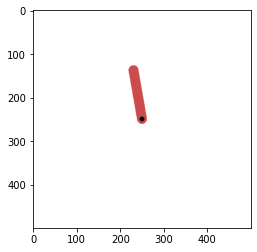

In [97]:
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    obs = np.expand_dims(obs, 0)
    action = agent.action(obs)
    obs, reward, done, _ = env.step(action_map(action))

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()

In [4]:
class CriticNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        # Add some dense layers with ReLU activations
        self.hidden_layer1 = tf.keras.layers.Dense(128, activation='relu')
        self.hidden_layer2 = tf.keras.layers.Dense(64, activation='relu')

        # Add a layer for the output value
        self.value = tf.keras.layers.Dense(1)
    
    def call(self, state, action):
        x = tf.concat((state, action), 1)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        return self.value(x)

In [18]:
class ActorNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        # Add some dense layers with ReLU activations
        self.hidden_layer1 = tf.keras.layers.Dense(128, activation='relu')
        self.hidden_layer2 = tf.keras.layers.Dense(64, activation='relu')

        # Add a layer for the output action
        self.action = tf.keras.layers.Dense(1, activation='tanh')
    
    def call(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        return 2 * self.action(x)

In [87]:
class DDPG:
    def __init__(self, critic, actor):
        self.critic = critic
        self.actor = actor
        self.gamma = 0.95
        
        # Create optimizers
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

        # Parameters for minibatching
        self.batch_size = 64
    
    def action(self, state):
        return self.actor(state).numpy()[0]
    
    def train(self, experience):
        state, action, reward, next_state, done = experience

        # Critic update
        with tf.GradientTape() as tape:
            target = reward + self.gamma * tf.stop_gradient(self.critic(next_state, self.actor(next_state))) * (1 - done)
            td_error = self.critic(state, action) - target
            loss = tf.reduce_mean(td_error**2, 0)
            
        # Get gradients and apply them to the model's parameters
        grads = tape.gradient(loss, self.critic.trainable_weights)
        self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_weights))
        
        # Critic update
        with tf.GradientTape() as tape:
            action = self.actor(state)
            value = self.critic(state, action)
            loss = -value
            
        # Get gradients and apply them to the model's parameters
        grads = tape.gradient(loss, self.actor.trainable_weights)
        self.actor_optimizer.apply_gradients(zip(grads, self.actor.trainable_weights))

In [89]:
critic = CriticNetwork()
actor = ActorNetwork()
agent = DDPG(critic, actor)

In [91]:
returns = []
for i in range(1000):
    obs = env.reset()
    obs = np.expand_dims(obs, 0)
    total_return = 0
    done = False
    while not done:
        
        if np.random.rand() > .2:
            action = agent.action(obs)
        else:
            action = np.random.rand(1)*4 - 2
        
        next_obs, reward, done, _ = env.step(action)
        next_obs = np.expand_dims(next_obs, 0)
        
        experience = obs, np.expand_dims(action, 0), reward, next_obs, done
        agent.train(experience)
        
        obs = next_obs
        total_return += reward
    
    returns.append(total_return)
    if len(returns) > 100:
        returns.pop(0)
    print("Episode {}: Running Average = {}".format(i, sum(returns)/len(returns)), flush=True, end='\r')

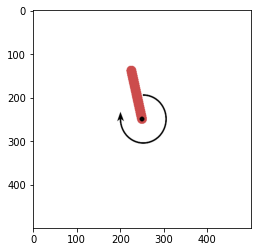

In [92]:
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    obs = np.expand_dims(obs, 0)
    action = agent.action(obs)
    obs, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()